### Decision Trees

Task: Classification, Regression

### 1. Concept

1.1. <ins>Assumption</ins>: No implicit assumptions. Data isn't required to be normalised or scaled for training. Few missing values do not affect training.

1.2. <ins>Summary</ins>: A tree is learnt by recursively splitting the training data in two, such that impurity (or variance in case of regression) is minimised at each split. Training stops if all leaves are pure or given preconditions are met. A test point traverses down the tree from the root to a leaf, and the mode (or mean) of training points in that leaf is returned as the test prediction.

1.3. <ins>Impurity functions</ins>: We use the Gini Impurity or Entropy to measure how impure a set is and quantify if a split is good while building the tree.

Gini Impurity:

Let

>$S = \{(x_1, y_1),......,(x_n, y_n)\}$<br>
>$S_k = \{(x,y) \in S \hspace{1ex}\forall y = k\}$<br>
>$\therefore P_k = \frac{|S_k|}{|S|}$

Then, the Gini Impurity of the set S is defined as

> $G(S) = \displaystyle\sum_{k=1}^{K} P_k(1-P_k)$


Entropy:

Entropy is derived from KL Divergence.

KL Divergence measures how different two distributions are. We take the worst case distribution where all classes are equally likely as a pathalogical reference case, and quantify how homogenous or pure a target distribution is by measuring how divergent it is from the reference. 

KL divergence is always non-negative and can maximally be infinte.

Reference distribution Q:

> $Q_1 = Q_2 = Q_3 = .....= Q_k = \frac{1}{K}\hspace{2ex}\hspace{3ex}$

KL divergence of target distribution P from Q

> $KL(P, Q) = \displaystyle\sum_{k=1}^{K} P_k*log(\frac{P_k}{Q_k})$ <br>
> $\hspace{9ex}= \sum P_k.log(P_k) + \sum P_k.log(K)$ <br>
> $\hspace{9ex}= \sum P_k.log(P_k)) + log(K)\sum P_k$<br>
> $\hspace{9ex}= \sum P_k.log(P_k) + log(K)$

As $log(K)$ is a constant, maximising KL divergence is equivalent to maximising the term $ \sum P_k.log(P_k)$ which is equivalent to minimising the negative of that term. This negative of the term i.e. $ - \sum P_k.log(P_k)$ is called Entropy.

As we build a tree, the feature thresholds which minimise resultant entropy of the tree are chosen for splitting the data into two child nodes.

Entropy change over a split
>$\Delta H = H(S_{parent}) - H(S_{child})$

>where $H(S_{child}) = P_{L}H(S_{L}) + P_{R}H(S_{R})$<br>
>and $P_{L}=\frac{|S_L|}{|S|}$ $P_{R}=\frac{|S_R|}{|S|}$

### 2. Implementation

The following concepts of a decision tree are implemented below:
- Building a tree
- Prediction/Evaluation
- Pruning 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [2]:
## generate dataset for binary classification

# initialise and set seed
N = 200
np.random.seed(3)

# first gaussian with label as 1
mean1, covariance1 = [9, 8], [[.8, 1], [.25, 1]]             
data1 = np.random.multivariate_normal(mean1, covariance1, N, 'ignore') 
label1 = np.ones(N)

# second gaussian with label as 0
mean2, covariance2 = [4, 8], [[.8, -.5], [2, .1]] 
data2 = np.random.multivariate_normal(mean2, covariance2, N, 'ignore') 
label2 = np.ones(N) * -1

# stack gaussians and lables to get X and y
X = np.vstack((data1, data2))
y = np.concatenate((label1, label2))


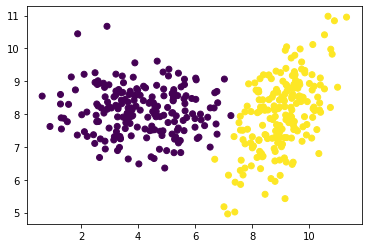

In [3]:
# plot data

plt.figure()

plt.scatter(X[:,0], X[:,1], c = y)

plt.show()

In [4]:
class Node:
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, parent=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.parent = parent
        self.value = value
    
    def is_leaf(self):
        return self.value is not None
        

In [55]:
class decision_tree:
    
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
     
    
    ## Build Decision tree
    
    def _mode(self, y):
        d = {}
        for i in y:
            if i in d:
                d[i] += 1
            else:
                d[i] = 1
        return max(d, key = d.get)
    
           
    def _is_finished(self, depth):
        if depth == self.max_depth or self.n_labels == 1 or self.n_samples < self.min_samples_split:
            return True
        return False
    
    
    def _entropy(self, y):
        labels = np.unique(y)
        tot = len(y)
        entropy = 0
        for i in labels:
            p = sum(y==i)/tot
            entropy -= (p)*np.log(p)
        return entropy
    
    
    def _create_split(self, X, thresh):
        left_idx = np.argwhere(X <= thresh).flatten()
        right_idx = np.argwhere(X > thresh).flatten()
        return left_idx, right_idx
    
    
    def _information_gain(self, X, y, thresh):
        parent_loss = self._entropy(y)
        left_idx, right_idx = self._create_split(X, thresh)
        n, n_left, n_right = len(y), len(left_idx), len(right_idx)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        child_loss = (n_left/n)*self._entropy(y[left_idx]) + (n_right/n)*self._entropy(y[right_idx])
        self.information_gain = parent_loss - child_loss
        return parent_loss - child_loss
    
    
    def _best_split(self, X, y):
        split = {'score':-1, 'feat':None, 'thresh':None}
        
        for feat in range(X.shape[1]):
            X_feat = X[:, feat]
            for thresh in X_feat:
                score = self._information_gain(X_feat, y, thresh)
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['thresh'] = thresh
                    
        return split['feat'], split['thresh']
        
        
    def _build_tree(self, X, y, depth = 0):
        
        # if tree building is finished at a node, return it as leaf node
        
        self.n_samples, self.n_features = X.shape
        self.n_labels = len(np.unique(y))
        
        if self._is_finished(depth):
            mode_label = self._mode(y)
            return Node(value=mode_label)
        
        # otherwise grow child node recursively by maximising information gain
        
        best_feat, best_thresh = self._best_split(X, y)

        left_idx, right_idx = self._create_split(X[:, best_feat], best_thresh)
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth+1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth+1)
        return Node(best_feat, best_thresh, left_child, right_child)
    
    def fit(self, X, y):
        self.root = self._build_tree(X,y)
    
    ## Evaluation
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)
        
    ## Pruning
    
    # Catalog all twigs
    # Count the total number of leaves in the tree
    # While the number of leaves in the tree exceeds the desired number:
    #  a. Find twig with least Information Gain
    #  b. Remove all child nodes of the twig
    #  c. Relabel twig as leaf
    #  d. Update the leaf count


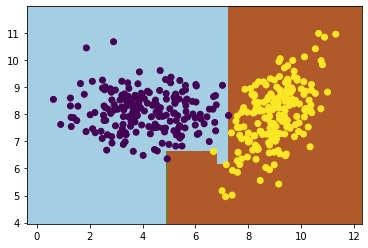

In [56]:
# plot decision boundary

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

h = 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

z = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]

dtree = decision_tree()

dtree.fit(X,y)

z1 = np.fromiter((dtree.predict(z)), 'float')

z1 = z1.reshape(xx.shape)

plt.figure()

plt.contourf(xx, yy, z1, cmap=plt.cm.Paired)

plt.scatter(X[:,0], X[:,1], c = y)

### 3. Closing Notes

With more branching Training error goes down to zero but test error dips and goes back up with (overfitting)

Splits are axis aliant. The resulting high Bias and Variance seen in decision trees can be reduced significantly by Boosting and Bagging techniques.